# Simple features

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Harris corner detector

### 1. Gaussian kernels

$lim_{sigma\rightarrow 0}\left(g(x)\right) = \delta(x)$

$lim_{sigma\rightarrow 0, x < 0, x\rightarrow 0}\left(g(x)\right) = \delta(x)$

$lim_{sigma\rightarrow 0, x > 0, x\rightarrow 0}\left(g(x)\right) = -\delta(x)$

In [79]:
def gaussian1DKernel(sigma):
    """Return the 1D gaussian kernel and its derivative.
    
    Parameters
    ----------
    sigma: float
        variance
    
    Return
    ------
    g, gx: numpy arrays
        gaussian kernel and its derivative
    """
    if sigma == 0:
        return np.ones(1), np.array([1, -1])

    h = np.ceil(5 * np.ceil(sigma))
    x = np.arange(-h, h + 1)

    g = np.exp(- x ** 2 / (2 * sigma ** 2))
    g /= g.sum()
    
    gx = - x / sigma ** 2 * g

    return g, gx

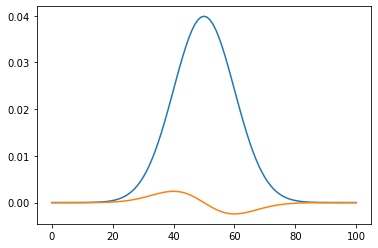

In [78]:
g, gx = gaussian1DKernel(sigma=10)
fig, ax = plt.subplots(1)
ax.plot(g)
ax.plot(gx);

### 2. Gaussian smoothing

In [43]:
def gaussianSmoothing(im, sigma):
    """Return the gaussian smoothed image and gaussian smoothed derivatives.
    
    Parameters
    ----------
    im: numpy array
        image
    sigma: float
        variance of the gaussian kernel
    
    Returns
    -------
    I: numpy array
        Gaussian smoothed image of im
    Ix, Iy: numpy arrays
        Smoothed derivatives of the image
    """
    g, gx = gaussian1DKernel(sigma)
    I = applyTwoFilters(im, g.reshape(1, -1), g.reshape(-1, 1))
    Ix = applyTwoFilters(im, gx.reshape(1, -1), g.reshape(-1, 1))
    Iy = applyTwoFilters(im, g.reshape(1, -1), gx.reshape(-1, 1))
    return I, Ix, Iy

def applyTwoFilters(I, g, h):
    I = cv2.filter2D(I, -1,  g)
    return cv2.filter2D(I, -1,  h)

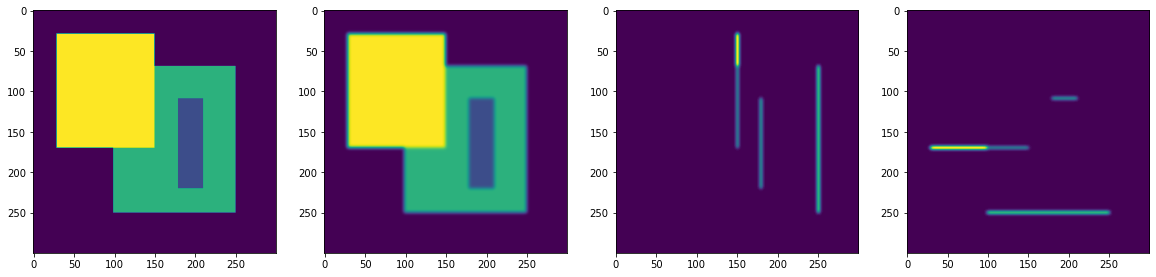

In [205]:
im = cv2.imread("data/week06_data/TestIm1.png", 0)

I, Ix, Iy = gaussianSmoothing(im, sigma=2)

fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(im)
ax[1].imshow(I);
ax[2].imshow(Ix / np.max(Ix));
ax[3].imshow(Iy / np.max(Iy));

### 3. Smoothed hessian

In [135]:
def smoothedHessian(im, sigma, epsilon):
    """
    Return the hessian of the images.
    
    Parameters
    ----------
    sigma, epsilon: int
        width of the gaussian kernels
    
    Return
    ------
    C: float
        smoothed hessian
    """
    _, Ix, Iy = gaussianSmoothing(im, sigma)
    g_epsilon, _ = gaussian1DKernel(sigma)

    a = cv2.filter2D(Ix ** 2, -1,  g_epsilon)
    b = cv2.filter2D(Iy ** 2, -1,  g_epsilon)
    c = cv2.filter2D(Ix * Iy, -1,  g_epsilon)
    return np.array([
        [a, c],
        [c, b],
    ])

#### Having a non zero epsilon means that we are averaging the value over  a small area, which ensure robustness against noise.

### 4. Harris measure

In [136]:
def harrisMeasure(im, sigma, epsilon, k):
    """Return the harris measure."""
    C = smoothedHessian(im, sigma, epsilon)
    a, b, c = C[0, 0], C[1, 1], C[0, 1]
    return a * b - c ** 2 - k * (a + b) ** 2

#### If epsilon is 0 then a * b == c; if sigma is 0 then a == b == c. In both cases, at least one of the eigenvalues is 0.

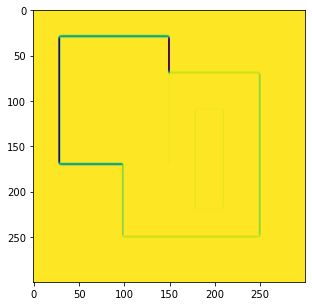

In [175]:
I = harrisMeasure(im, sigma=1, epsilon=1, k=0.6)
plt.figure(figsize=(5, 5))
plt.imshow(I);

### 5. Corner detector

In [167]:
def cornerDetector(im, sigma=1, epsilon=1, k=0.06, tau=5):
    """Return corners coordinates in the image."""
    r = harrisMeasure(im, sigma, epsilon, k)
    local_max = np.zeros(im.shape, dtype=bool)
    local_max[1:-1, 1:-1] = (
          (r[1:-1, 1:-1] > r[1:-1, 2:  ]) 
        & (r[1:-1, 1:-1] > r[1:-1,  :-2])
        & (r[1:-1, 1:-1] > r[2:  , 1:-1])
        & (r[1:-1, 1:-1] > r[ :-2, 1:-1])
    )
    r[~local_max] = 0
    return np.argwhere(r > tau)

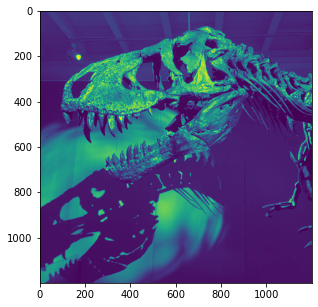

In [241]:
corners = cornerDetector(im, tau = 5e4)
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.imshow(im)
ax.plot(corners[:,1], corners[:,0], 'ro');

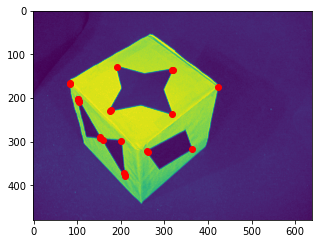

In [242]:
im = cv2.imread("data/week06_data/Box3.bmp")[:, :, ::-1]
im = np.sum(im, axis=2) / 3
corners = cornerDetector(im, sigma=2, tau = 1e3)
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.imshow(im)
ax.plot(corners[:,1], corners[:,0], 'ro');

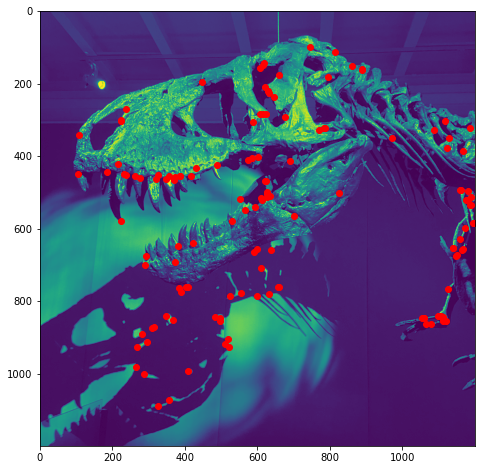

In [251]:
im = cv2.imread("data/week06_data/tristan.png")[:, :, ::-1]
im = np.sum(im, axis=2) / 3
corners = cornerDetector(im, sigma=2, tau = 2e4)
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(im)
ax.plot(corners[:,1], corners[:,0], 'ro');

#### We can see that on the last example (skeleton), getting the same points in another image is likely to fail.

## Canny edge detection

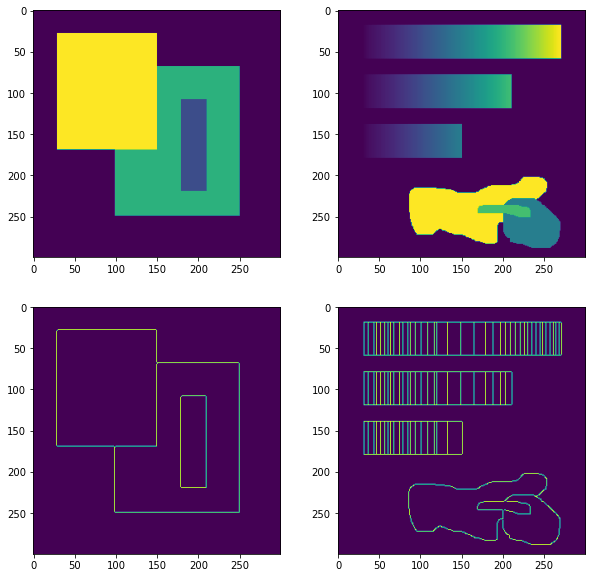

In [264]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i in range(2):
    im = cv2.imread(f"data/week06_data/TestIm{i + 1}.png", 0)
    canny = cv2.Canny(im, 1, 5)
    ax[0][i].imshow(im)
    ax[1][i].imshow(canny)